# Reproduction of Fig 9

In [35]:
import math
import numpy as np
from pylab import *
import os, os.path
import json
import glycogen_module as gm
import random
import pandas as pd
import json

## By default settings: parameters obtain from best-fit

Here we chose the parameters obtained from the best-fit algorithm. Fig 9 has been obtained with 200 simulations with $N = 5000$. 

By default, here we have 5 runs with $N= 2500$ (computational time around 1min)

In [36]:
with open("parameters.json", "r") as f:
    parameters = json.load(f)
    
parameters['size_spec_gbe_spacing'] = 1
parameters['size_spec_gbe_leftover'] = 3
parameters['size_spec_gbe_transferred'] = 3
parameters['b']=5.4
parameters['GS'] = 0.6
parameters['GBE'] = 1.0
parameters['number_of_glucose_to_be_fixed']= 2500

Number_of_simulations = 5

path_of_local_folder = os.getcwd()
folder_name = '/data_for_fig9'
os.mkdir(path_of_local_folder+folder_name)
data_path = path_of_local_folder+folder_name

## Requiered functions

In [37]:
def Gillespie_step(structure, C):
    ''' This functions takes concentrations of the enzymes and the structure info of a glycogen granules and
    return what is the next reaction to occurs and which time has been spent. (Following a gillespie algorithm)
    '''
    #propensity assuming mass action kinetics
    h_gs = C["GS"]*len(structure.Find_chain_for_gs())
    h_gp = C["GP"]*len(structure.Find_chain_for_gp())
    h_gbe = C["GBE"]*len(structure.Find_chain_for_gbe())
    h_gde = C["GDE"]*len(structure.Find_chain_for_gde())
    
    a = h_gs + h_gp + h_gbe + h_gde
    
    if a == 0:
        return "no reaction can be proceed, all propensities are zero",0
    r2=random.uniform(0,a)    
    r1=random.uniform(0,1)	
    
    d_t = (1/a)*math.log(1/r1)
    if r2 < h_gs :
        return "Act_gs",d_t
    elif r2 >= h_gs and r2 < h_gs + h_gp :
        return "Act_gp",d_t
    elif r2 >=  h_gs + h_gp  and r2 < h_gs + h_gp + h_gbe :
        return "Act_gbe",d_t
    elif r2 >=  h_gs + h_gp + h_gbe  and r2 < h_gs + h_gp + h_gbe + +h_gde:
        return "Act_gde",d_t   
    
def cumulative_cld(path_of_folder:str):
    cld_cumulated=[];

    for i in range(len(os.listdir(path_of_folder))):
        file_name='glycogen_structure'+str(i+1)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)
        
        distrib = cld(my_granule_data)
        cld_cumulated= cld_cumulated + distrib

    return(cld_cumulated)

def hist_into_curve(distrib:list):
    'this function takes an histogram list and return X and Y arrays to plot the associated curve'
    
    total=len(distrib)
    maximum=max(distrib)
    #print(maximum)
    X=np.linspace(0,maximum,maximum+1)
    Y=[]
    for k in X:
        counter=0
        for i in range(len(distrib)):
            if k==distrib[i]:
                counter+=1
        Y.append(counter)   
    
    Y=np.asarray(Y)
    return X, Y*1.0/total 

def cld(dict):
    histo=[]
    for chain in dict.values(): 
        histo.append(len(chain['glucose_location']))
    return histo 

## Generating the data

In [38]:
for i in range(Number_of_simulations):
    my_granule = gm.glycogen_structure(parameters, 2,1)

    N = my_granule.number_of_glucose_fixed()  
    C0 = {"GS":parameters['GS'],"GBE":parameters['GBE'],"GP":0.00,"GDE":0.00}          # here set GS = 1.0 and GBE = 0.1 if you want to produce the figure for gamma = 10.0


    while N < parameters['number_of_glucose_to_be_fixed']:
        if N%5000 == 0:
            print('avancement = ', 100*N/parameters['number_of_glucose_to_be_fixed'], '%','   part 1/2')
        reaction, time = Gillespie_step(my_granule, C0)

        if reaction == 'Act_gs':
            my_granule.Act_gs()
        elif reaction == 'Act_gp' and N>10:
            my_granule.Act_gp()
        elif reaction == 'Act_gbe':
            my_granule.Act_gbe_flexible_model()
        elif reaction == 'Act_gde':
            my_granule.Act_gde()


        N = my_granule.number_of_glucose_fixed()
 
    name = 'glycogen_structure'+str(i+1)+'.json'
    my_granule.write_structure(data_path+'/'+name)   

## Reading outputs and plot

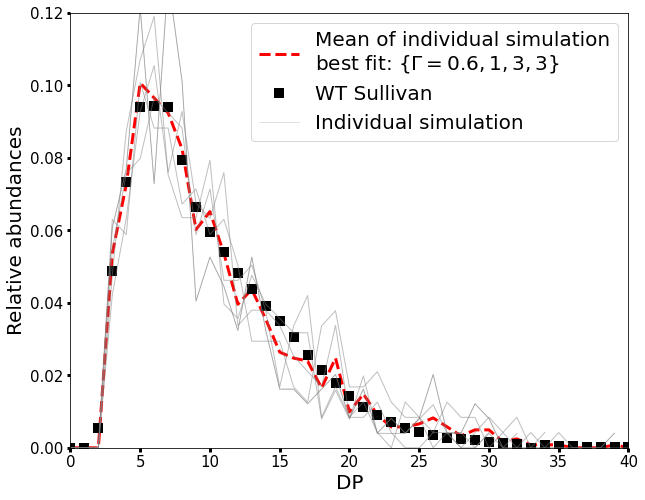

In [39]:
distrib = cumulative_cld(data_path)
DP, Abundance_mean = hist_into_curve(distrib)

number_of_file = len(os.listdir(data_path))


df = pd.read_csv('wt-sullivan.csv')
Y_wt = df['dp'].tolist()
X = np.linspace(0,40,41)

liste = distrib
bins1 = np.linspace(0,max(liste), max(liste)+1)
plt.figure(figsize=(10,8))
plt.plot(DP,Abundance_mean,color='red',ls='dashed',markeredgewidth=6 ,lw = 3, label=r'Mean of individual simulation'+'\n' + r'best fit: $\{\Gamma = 0.6,1,3,3\}$')
plt.plot(X,0.01*np.asarray(Y_wt),linestyle = 'None',color = 'black',marker='s',label = 'WT Sullivan',markeredgewidth=4 )
plt.xlabel('DP', fontsize = 20)
plt.ylabel ('relative abundances', fontsize = 20)
plt.legend()

plt.xlim([0,40])
for i in range(number_of_file):
    path = data_path+'/glycogen_structure'+str(i+1)+'.json'
    with open(path, "r") as f:
        my_granule_data = json.load(f)
    distrib = cld(my_granule_data)
    DP, Abundance = hist_into_curve(distrib)
    plt.plot(DP,Abundance, color = 'grey', alpha = 0.5, lw = 1)
    
    
plt.plot(DP,Abundance, color = 'grey', alpha = 0.5, lw = 0.5, label = 'Individual simulation')
plt.legend(fontsize=16)
plt.ylim([0,.12])
plt.xlabel('DP',fontsize='20')
plt.ylabel('Relative abundances',fontsize='20')
plt.tick_params(axis='both',width=3,labelsize=15)
plt.legend(fontsize=20)
plt.savefig('fig9.png', dpi = 350 )
plt.show()